# ***In this Part I am gonna install kaggle library and then load the dataset***

In [1]:
!pip install kaggle

In [2]:
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [3]:
!chmod 600 ~/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [4]:
! kaggle datasets download msambare/fer2013

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
 85% 51.0M/60.3M [00:00<00:00, 192MB/s]
100% 60.3M/60.3M [00:00<00:00, 188MB/s]


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')

import os
import tensorflow as tf
import keras
import cv2

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers , models, optimizers

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.applications import ResNet50V2
from sklearn.metrics import confusion_matrix
def plot_curves(history):

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    epochs = range(len(history.history["loss"]))

    plt.figure(figsize=(15,5))

    #plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label = "training_loss")
    plt.plot(epochs, val_loss, label = "val_loss")
    plt.title("Loss")
    plt.xlabel("epochs")
    plt.legend()

    #plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label = "training_accuracy")
    plt.plot(epochs, val_accuracy, label = "val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("epochs")
    plt.legend()

In [6]:
import zipfile
zip_ref = zipfile.ZipFile('/content/fer2013.zip', 'r')
zip_ref.extractall('/content/')
zip_ref.close()

In [7]:
train_dir = '/content/train/'
test_dir = '/content/test/'

def Classes_Count( path, name):
    Classes_Dict = {}

    for Class in os.listdir(path):

        Full_Path = path + Class
        Classes_Dict[Class] = len(os.listdir(Full_Path))

    df = pd.DataFrame(Classes_Dict, index=[name])

    return df

Train_Count = Classes_Count(train_dir, 'Train').transpose().sort_values(by="Train", ascending=False)
Test_Count = Classes_Count(test_dir, 'Test').transpose().sort_values(by="Test", ascending=False)

In [8]:
img_shape = 224
batch_size = 64
train_data_path = '/content/train/'
test_data_path = '/content/test/'

In [9]:
pd.concat([Train_Count,Test_Count] , axis=1)

,Train,Test
happy,7215,1774
neutral,4965,1233
sad,4830,1247
fear,4097,1024
angry,3995,958
surprise,3171,831
disgust,436,111


<Axes: >

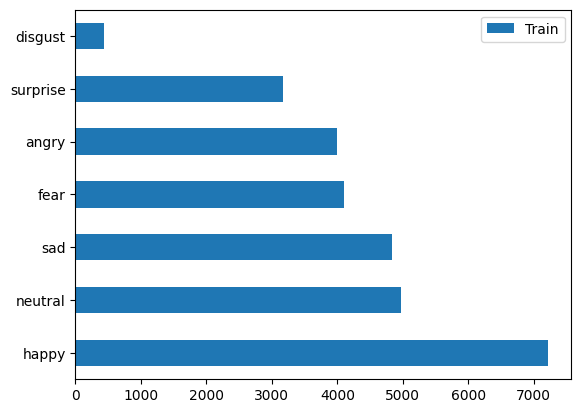

In [10]:
Train_Count.plot(kind='barh')

<Axes: >

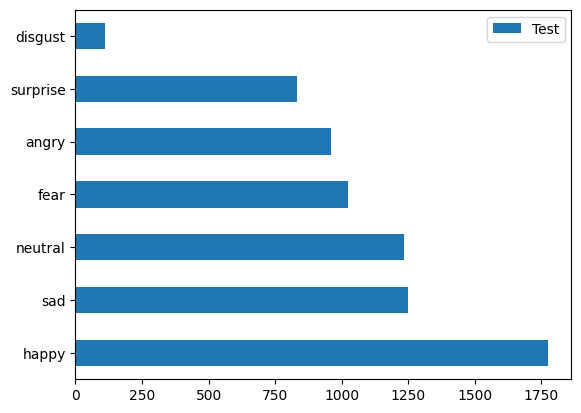

In [11]:
Test_Count.plot(kind='barh')

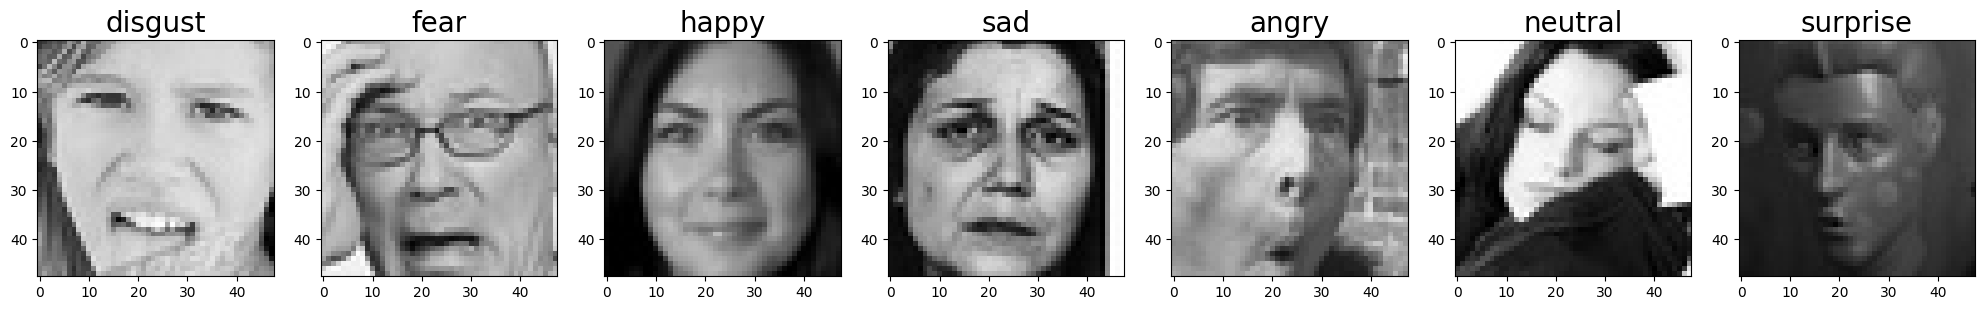

In [12]:
plt.style.use('default')
plt.figure(figsize = (25, 8))
image_count = 1
BASE_URL =  '/content/train/'

for directory in os.listdir(BASE_URL):
    if directory[0] != '.':
        for i, file in enumerate(os.listdir(BASE_URL + directory)):
            if i == 1:
                break
            else:
                fig = plt.subplot(1, 7, image_count)
                image_count += 1
                image = cv2.imread(BASE_URL + directory + '/' + file)
                plt.imshow(image)
                plt.title(directory, fontsize = 20)

In [13]:
train_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
        rotation_range=10,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest',
    )


test_preprocessor = ImageDataGenerator(
    rescale = 1 / 255.,
)

train_data = train_preprocessor.flow_from_directory(
    train_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size,
    subset='training',
)
test_data = test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size,
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [14]:
# 224,224,3
ResNet50V2 = tf.keras.applications.ResNet50V2(input_shape=(224, 224, 3),
                                               include_top= False,
                                               weights='imagenet'
                                               )

94668760/94668760 [==============================] - 1s 0us/step


In [15]:
# Freezing all layers except last 50
ResNet50V2.trainable = True

for layer in ResNet50V2.layers[:-5]:
    layer.trainable = False

In [16]:
def Create_ResNet50V2_Model():

    model = Sequential([
                      ResNet50V2,
                      Dropout(0.25),
                      BatchNormalization(),
                      Flatten(),
                      Dense(64, activation='relu'),
                      BatchNormalization(),
                      Dropout(.5),
                      Dense(7,activation='softmax')
                    ])
    return model

In [17]:
ResNet50V2_Model = Create_ResNet50V2_Model()

ResNet50V2_Model.summary()

ResNet50V2_Model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 dropout (Dropout)           (None, 7, 7, 2048)        0         
                                                                 
 batch_normalization (Batch  (None, 7, 7, 2048)        8192      
 Normalization)                                                  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 64)                6422592   
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256       
 chNormalization)                                       

In [18]:
# Create Callback Checkpoint
checkpoint_path = "ResNet50V2_Model_Checkpoint"

Checkpoint = ModelCheckpoint(checkpoint_path, monitor="val_accuracy", save_best_only=True)

# Create Early Stopping Callback to monitor the accuracy
Early_Stopping = EarlyStopping(monitor = 'val_accuracy', patience = 7, restore_best_weights = True, verbose=1)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning
Reducing_LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                  factor=0.2,
                                                  patience=2,
#                                                   min_lr=0.00005,
                                                  verbose=1)

callbacks = [Early_Stopping, Reducing_LR]

steps_per_epoch = train_data.n // train_data.batch_size
validation_steps = test_data.n // test_data.batch_size

In [19]:
ResNet50V2_history = ResNet50V2_Model.fit(train_data ,validation_data = test_data , epochs=35, batch_size=batch_size,
                                         callbacks = callbacks, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)

Epoch 1/35
448/448 [==============================] - 434s 944ms/step - loss: 1.7365 - accuracy: 0.4178 - val_loss: 1.3798 - val_accuracy: 0.5117 - lr: 0.0010
Epoch 2/35
448/448 [==============================] - 400s 892ms/step - loss: 1.4161 - accuracy: 0.4807 - val_loss: 1.2239 - val_accuracy: 0.5386 - lr: 0.0010
Epoch 3/35
448/448 [==============================] - 404s 902ms/step - loss: 1.3082 - accuracy: 0.5101 - val_loss: 1.2101 - val_accuracy: 0.5439 - lr: 0.0010
Epoch 4/35
448/448 [==============================] - 398s 886ms/step - loss: 1.2663 - accuracy: 0.5267 - val_loss: 1.2066 - val_accuracy: 0.5467 - lr: 0.0010
Epoch 5/35
448/448 [==============================] - 391s 873ms/step - loss: 1.2423 - accuracy: 0.5356 - val_loss: 1.2118 - val_accuracy: 0.5572 - lr: 0.0010
Epoch 6/35
448/448 [==============================] - ETA: 0s - loss: 1.2146 - accuracy: 0.5460
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
448/448 [=======================

In [20]:
ResNet50V2_Score = ResNet50V2_Model.evaluate(test_data)

print("    Test Loss: {:.5f}".format(ResNet50V2_Score[0]))
print("Test Accuracy: {:.2f}%".format(ResNet50V2_Score[1] * 100))

113/113 [==============================] - 23s 206ms/step - loss: 1.1828 - accuracy: 0.6103
    Test Loss: 1.18282
Test Accuracy: 61.03%


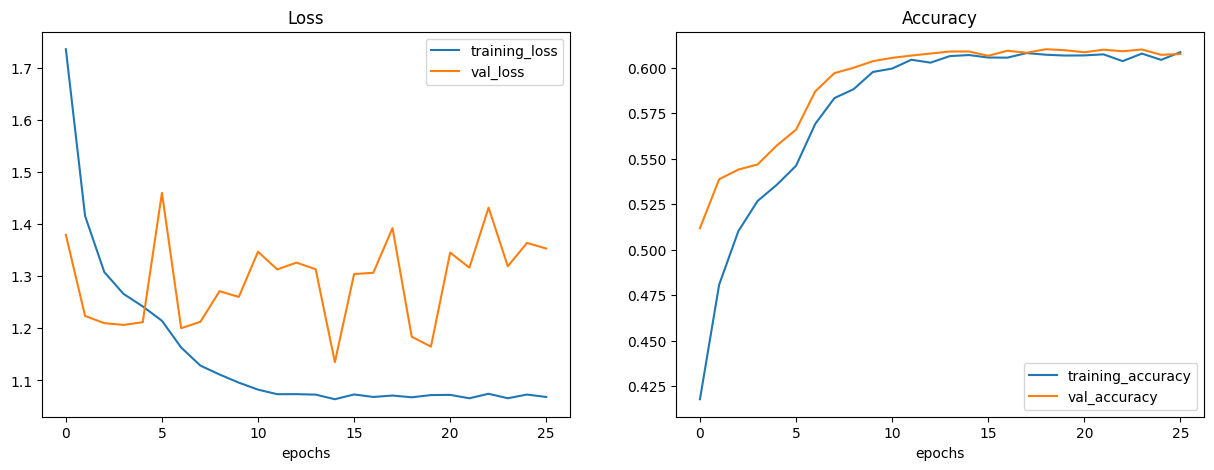

In [26]:
plot_curves(ResNet50V2_history)

In [22]:
ResNet50V2_Predictions = ResNet50V2_Model.predict(test_data)

# Choosing highest probalbilty class in every prediction
ResNet50V2_Predictions = np.argmax(ResNet50V2_Predictions, axis=1)

113/113 [==============================] - 34s 291ms/step


Text(0.5, 1.0, 'ResNet50V2 Confusion Matrix')

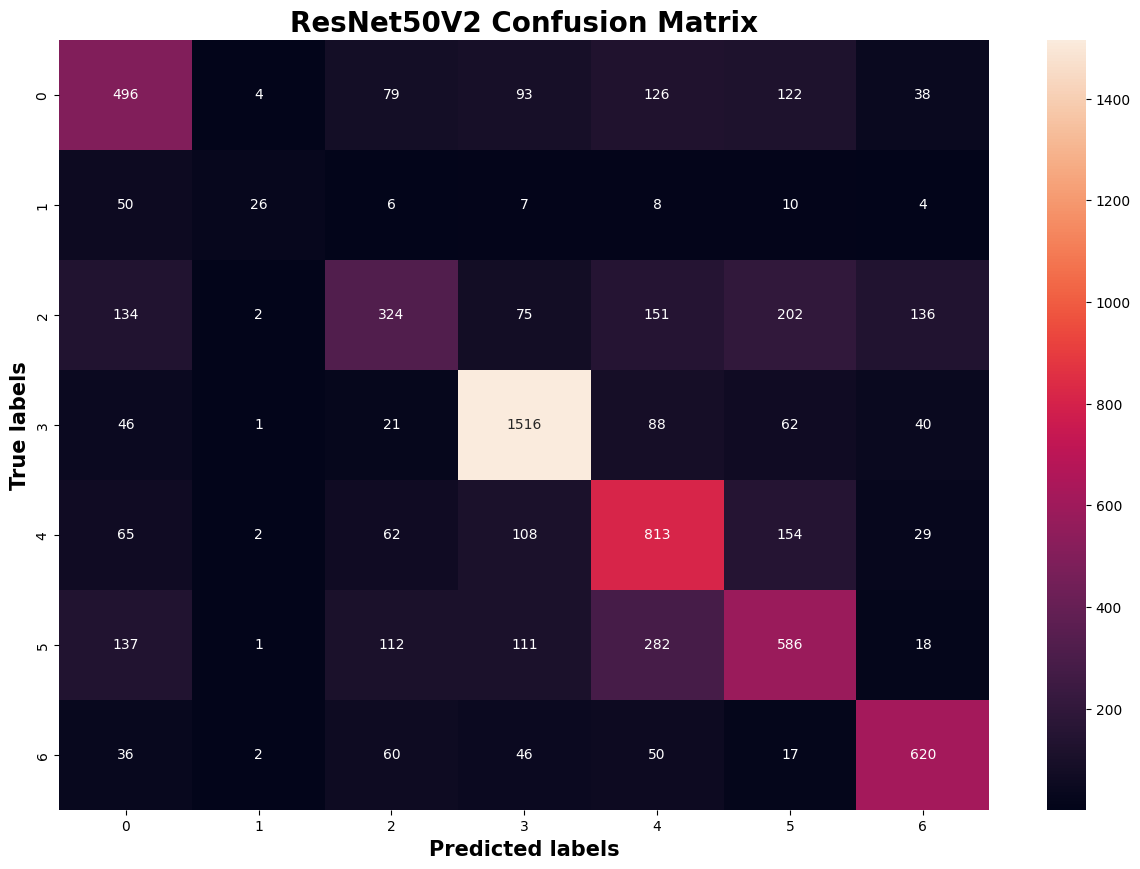

In [28]:
import seaborn as sns
fig , ax= plt.subplots(figsize=(15,10))

cm=confusion_matrix(test_data.labels, ResNet50V2_Predictions)

sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels',fontsize=15, fontweight='bold')
ax.set_ylabel('True labels', fontsize=15, fontweight='bold')
ax.set_title('ResNet50V2 Confusion Matrix', fontsize=20, fontweight='bold')

In [29]:
Emotion_Classes = ['Angry',
                  'Disgust',
                  'Fear',
                  'Happy',
                  'Neutral',
                  'Sad',
                  'Surprise']

In [30]:
# Shuffling Test Data to show diffrent classes
test_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
    )

test_generator = test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=True,
    batch_size=batch_size,
)

Found 7178 images belonging to 7 classes.


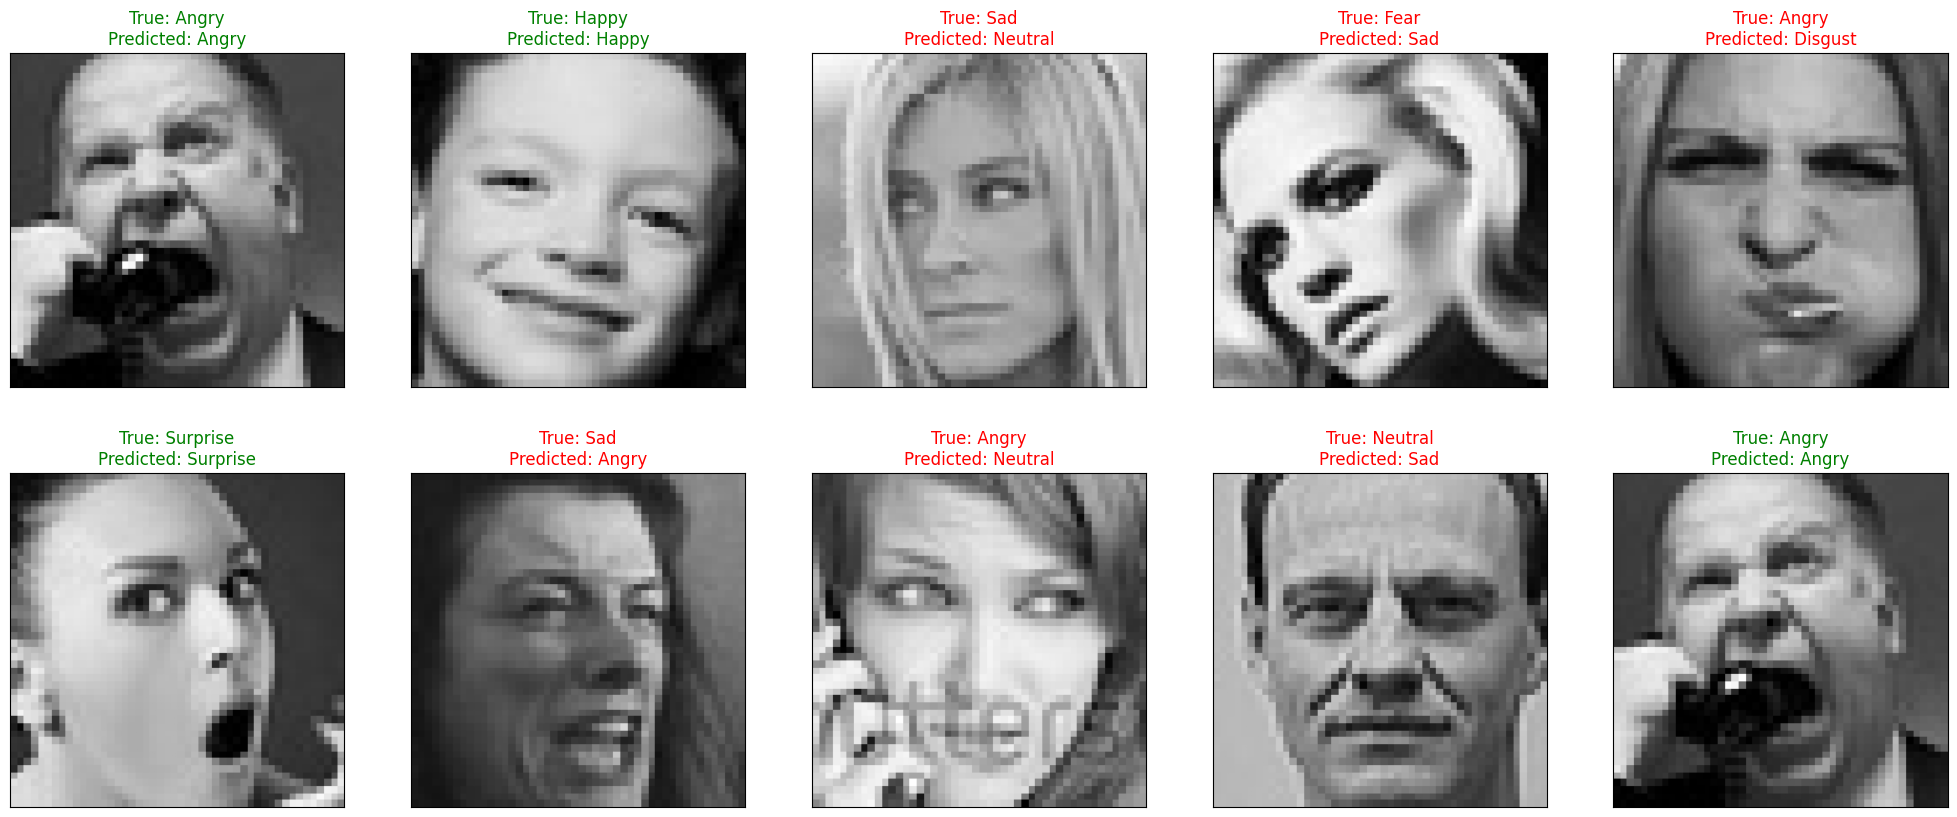

<Figure size 640x480 with 0 Axes>

In [31]:
# Display 10 random pictures from the dataset with their labels

Random_batch = np.random.randint(0, len(test_generator) - 1)

Random_Img_Index = np.random.randint(0, batch_size - 1 , 10)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):

    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]

    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]])

    Model_Prediction = np.argmax(ResNet50V2_Model.predict( tf.expand_dims(Random_Img, axis=0) , verbose=0))

    ax.imshow(Random_Img)

    if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction]:
          color = "green"
    else:
          color = "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)
plt.show()
plt.tight_layout()